## Plot training convergence for all ML models

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Collect and stratify model outputs

In [2]:
# for these ML models:
ML_models = ["SVM", "RF", "MLR", "DNN"]

# we have run 10 replicates:
replicates = np.linspace(1,10,10, dtype=int)

# we have these feature sets:
feature_sets = ["APFP", "ECFP6", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL",  "TOPOL", "X-NOISE"]


In [3]:
n_calls = 50
mae_outputs = []

for ml_model in ML_models:
    mae_outputs_this_model = [ml_model]
    for feature_set in feature_sets:
        # we want to compute both mean and std of error (across replicates):
        errors_all_replicates = []
                
        for replicate in replicates:
            path_to_mae_file = ml_model+"/output/"+feature_set+"/mae_per_callrepl"+str(replicate)+".csv"
            mae_df = pd.read_csv(path_to_mae_file, error_bad_lines=False, usecols=[0,1])
            mae_df = mae_df.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
            
            # now collect mae outputs over the five folds:
            fold_errors = []
            for fold in [1,2,3,4,5]:
                mae_values_per_call = mae_df.loc[mae_df["Fold"] == fold]["MAE (kcal/mol)"].values
                # Due to I/O issues some outputs may have odd number of calls; correct these:
                mae_values_per_call = list(mae_values_per_call)
                if len(mae_values_per_call) > n_calls:
                    mae_values_per_call = mae_values_per_call[:n_calls]
                elif len(mae_values_per_call) < n_calls:
                    n_missing = n_calls - len(mae_values_per_call)
                    last_call_mae = mae_values_per_call[-1]
                    for missing_value in range(n_missing):
                        mae_values_per_call.append(last_call_mae)
                # now that we have stratified the mae_outputs, append:
                fold_errors.append(list(np.minimum.accumulate(mae_values_per_call)))
                
            # and compute the average error of the cumulative minimum of these folds:
            error_minima_this_repl = np.mean(fold_errors, axis=0)
            errors_all_replicates.append(error_minima_this_repl)
        
        # now that we have the 10 error arrays, compute mean error per call and std:
        mean_errors = np.mean(errors_all_replicates, axis=0)
        std_errors = np.std(errors_all_replicates, axis=0)
        
        # append to large nested list to plot in next cells:
        
        mae_outputs_this_model.append([feature_set, mean_errors, std_errors])  
    mae_outputs.append(mae_outputs_this_model)

Data is now compiled and clean; takes the shape [[ml_model, [feature_type, [mean_errors], [std_errors]], ..]]

## Plotting

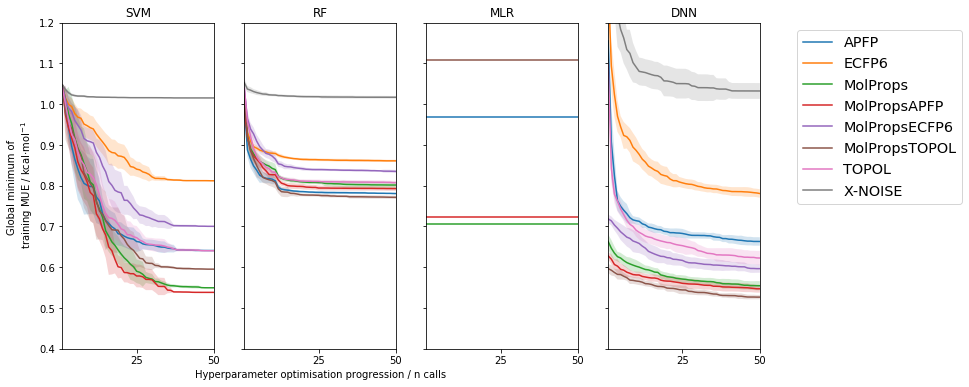

In [4]:
# declare x variable (for x axes)
x = np.linspace(1, n_calls, n_calls)

# generate an axis for every ML model:
fig, axes = plt.subplots(nrows=1, ncols=len(ML_models), sharey=True)

# extract lowest MAE value:
lowest_mae = np.inf

# plot each ml model to an axis:
for model_mae_output, ax in zip(mae_outputs, axes):
    
    ml_model = model_mae_output[0]
    ml_model_outputs = model_mae_output[1:]
    
       
    # now process this model's data per feature type:
    for mae_data_collection in ml_model_outputs:
        
        feature_type = mae_data_collection[0]   
        
        mae_values = mae_data_collection[1]
        # get the lowest mae value for this instance, update lowest mae if applicable:
        if mae_values[-1] < lowest_mae:
            lowest_mae = mae_values[-1]
        
        mae_stds = mae_data_collection[2]
        
        
        # standard devation bounds for confidence regions:
        y1 = [i - sd for i, sd in zip(mae_values, mae_stds)]
        y2 = [i + sd for i, sd in zip(mae_values, mae_stds)]
        
        ax.fill_between(x, y1, y2,
                alpha=0.2,
                #label='Standard deviation'
               )
        ax.plot(x, mae_values, label=feature_type)
        
    ax.set_title(ml_model)
    ax.set_ylim(0.4,1.2)
    ax.set_xlim(1,50)

# plot the lowest MAE:
# for ax in axes:
#     ax.axhline(lowest_mae, ls="--", c="black", lw=0.7)
    
lgd = plt.legend(fontsize="x-large", bbox_to_anchor=(1.2, 0.5, 0.5,0.5))
plt.rcParams.update({'font.size': 17})  
fig.set_size_inches(12.5, 6)
axes[0].set_ylabel("Global minimum of \n training MUE / kcal$\cdot$mol$^{-1}$")
axes[1].set_xlabel("Hyperparameter optimisation progression / n calls")

plt.savefig("OUTPUTS/training_convergence_hyb.png", dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Plot Null model training:

In [5]:
n_calls = 50
mae_outputs = []

for ml_model in ML_models:
    mae_outputs_this_model = [ml_model]
    for feature_set in feature_sets:
        # we want to compute both mean and std of error (across replicates):
        errors_all_replicates = []
                
        for replicate in replicates:
            path_to_mae_file = ml_model+"/output/"+feature_set+"/null_mae_per_callrepl"+str(replicate)+".csv"
            mae_df = pd.read_csv(path_to_mae_file, error_bad_lines=False, usecols=[0,1])
            mae_df = mae_df.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
            
            # now collect mae outputs over the five folds:
            fold_errors = []
            for fold in [1,2,3,4,5]:
                mae_values_per_call = mae_df.loc[mae_df["Fold"] == fold]["MAE (kcal/mol)"].values
                # Due to I/O issues some outputs may have odd number of calls; correct these:
                mae_values_per_call = list(mae_values_per_call)
                if len(mae_values_per_call) > n_calls:
                    mae_values_per_call = mae_values_per_call[:n_calls]
                elif len(mae_values_per_call) < n_calls:
                    n_missing = n_calls - len(mae_values_per_call)
                    last_call_mae = mae_values_per_call[-1]
                    for missing_value in range(n_missing):
                        mae_values_per_call.append(last_call_mae)
                # now that we have stratified the mae_outputs, append:
                fold_errors.append(list(np.minimum.accumulate(mae_values_per_call)))
                
            # and compute the average error of the cumulative minimum of these folds:
            error_minima_this_repl = np.mean(fold_errors, axis=0)
            errors_all_replicates.append(error_minima_this_repl)
        
        # now that we have the 10 error arrays, compute mean error per call and std:
        mean_errors = np.mean(errors_all_replicates, axis=0)
        std_errors = np.std(errors_all_replicates, axis=0)
        
        # append to large nested list to plot in next cells:
        
        mae_outputs_this_model.append([feature_set, mean_errors, std_errors])  
    mae_outputs.append(mae_outputs_this_model)

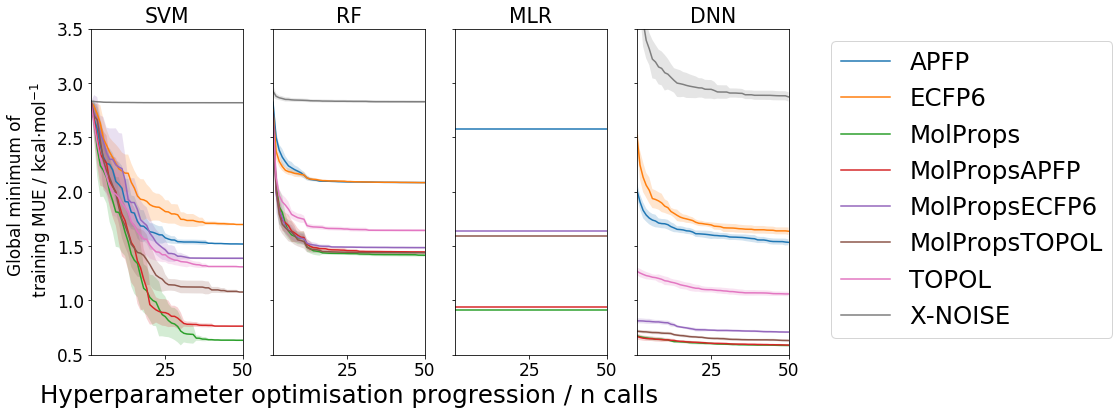

In [6]:
# declare x variable (for x axes)
x = np.linspace(1, n_calls, n_calls)

# generate an axis for every ML model:
fig, axes = plt.subplots(nrows=1, ncols=len(ML_models), sharey=True)

# extract lowest MAE value:
lowest_mae = np.inf

# plot each ml model to an axis:
for model_mae_output, ax in zip(mae_outputs, axes):
    
    ml_model = model_mae_output[0]
    ml_model_outputs = model_mae_output[1:]
    
       
    # now process this model's data per feature type:
    for mae_data_collection in ml_model_outputs:
        
        feature_type = mae_data_collection[0]   
        
        mae_values = mae_data_collection[1]
        # get the lowest mae value for this instance, update lowest mae if applicable:
        if mae_values[-1] < lowest_mae:
            lowest_mae = mae_values[-1]
        
        mae_stds = mae_data_collection[2]
        
        
        # standard devation bounds for confidence regions:
        y1 = [i - sd for i, sd in zip(mae_values, mae_stds)]
        y2 = [i + sd for i, sd in zip(mae_values, mae_stds)]
        
        ax.fill_between(x, y1, y2,
                alpha=0.2,
                #label='Standard deviation'
               )
        ax.plot(x, mae_values, label=feature_type)
        
    ax.set_title(ml_model)
    ax.set_ylim(0.5,3.5)
    ax.set_xlim(1,50)

# plot the lowest MAE:
# for ax in axes:
#     ax.axhline(lowest_mae, ls="--", c="black", lw=0.7)

lgd = plt.legend(fontsize="x-large", bbox_to_anchor=(1.2, 0.5, 0.5,0.5))    
plt.rcParams.update({'font.size': 17})  
fig.set_size_inches(12.5, 6)
axes[0].set_ylabel("Global minimum of \n training MUE / kcal$\cdot$mol$^{-1}$")
axes[1].set_xlabel("Hyperparameter optimisation progression / n calls", fontsize="x-large")

plt.savefig("OUTPUTS/training_convergence_null.png", dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()